### Прогноз размещения по неделям на площадке (отрасли + регионы закупок) 

In [80]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [81]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [82]:
data = pd.read_excel('ТоварыРегионыНедели.xlsx')
data.head()

,UnKod,Регион,Obl2,Область,W1,W2,W3,W4,W5,W6,...,W147,W148,W149,W150,W151,W152,W153,W154,W155,W156
0,1701,Адыгея,17,Бумага и изделия из бумаги,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1702,Башкортостан,17,Бумага и изделия из бумаги,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1703,Бурятия,17,Бумага и изделия из бумаги,0,0,0,2,0,4,...,0,0,0,0,0,0,0,0,0,0
3,1704,Алтай,17,Бумага и изделия из бумаги,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1705,Дагестан,17,Бумага и изделия из бумаги,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5292 entries, 0 to 5291
Columns: 160 entries, UnKod to W156
dtypes: int64(158), object(2)
memory usage: 6.5+ MB


In [84]:
columns=['Область', 'Регион', 'Obl2']
data.drop(columns, axis=1, inplace=True)

In [85]:
melt = data.melt(id_vars='UnKod', var_name='Week', value_name='Proc')

melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['UnKod', 'Week'])
melt.head()

,UnKod,Week,Proc
1630,102,1,0
6922,102,2,0
12214,102,3,0
17506,102,4,0
22798,102,5,0


In [86]:
week_start=128
week_end=140
s='Procedures (week '+str(week_start)+ ' - '+str(week_end)+ ')'

In [87]:
import copy

In [88]:
procedures = []
for Week in range(0, week_start):
    val=melt[melt['Week'] == Week]
    total=sum(val['Proc'])
    procedures.append(total)

In [89]:
melt2 =  melt.copy()
melt2['Last_Week_Proc'] = melt2.groupby(['UnKod'])['Proc'].shift()
melt2['Last_Week_Diff'] = melt2.groupby(['UnKod'])['Last_Week_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,UnKod,Week,Proc,Last_Week_Proc,Last_Week_Diff
12214,102,3,0,0.0,0.0
17506,102,4,0,0.0,0.0
22798,102,5,0,0.0,0.0
28090,102,6,0,0.0,0.0
33382,102,7,0,0.0,0.0


In [90]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814968 entries, 12214 to 822330
Data columns (total 5 columns):
UnKod             814968 non-null int64
Week              814968 non-null int32
Proc              814968 non-null int64
Last_Week_Proc    814968 non-null float64
Last_Week_Diff    814968 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 34.2 MB


In [91]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [92]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
abs_pr_errorB = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    yts=val['Proc']
    
    p = val['Last_Week_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
    abs_pr_errorB.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorB))

Week 128 - Error 0.60683, Real Total 8171.0 - Predict Total 14760.0, Abs Error 6589.0, Persent - 80.6
Week 129 - Error 0.50979, Real Total 8478.0 - Predict Total 8171.0, Abs Error 307.0, Persent - 3.6
Week 130 - Error 0.53117, Real Total 10689.0 - Predict Total 8478.0, Abs Error 2211.0, Persent - 20.7
Week 131 - Error 0.52592, Real Total 10552.0 - Predict Total 10689.0, Abs Error 137.0, Persent - 1.3
Week 132 - Error 0.54912, Real Total 6931.0 - Predict Total 10552.0, Abs Error 3621.0, Persent - 52.2
Week 133 - Error 0.50143, Real Total 5732.0 - Predict Total 6931.0, Abs Error 1199.0, Persent - 20.9
Week 134 - Error 0.48464, Real Total 6028.0 - Predict Total 5732.0, Abs Error 296.0, Persent - 4.9
Week 135 - Error 0.52346, Real Total 8726.0 - Predict Total 6028.0, Abs Error 2698.0, Persent - 30.9
Week 136 - Error 0.53077, Real Total 11009.0 - Predict Total 8726.0, Abs Error 2283.0, Persent - 20.7
Week 137 - Error 0.54137, Real Total 7739.0 - Predict Total 11009.0, Abs Error 3270.0, Pers

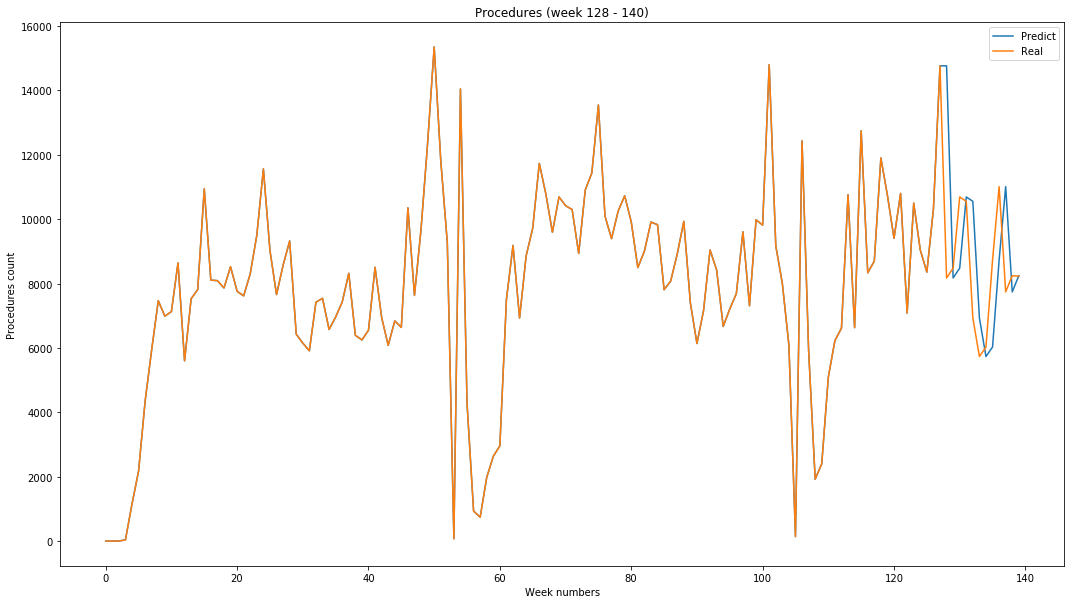

In [93]:

plt.plot(predict_ProcB)
plt.plot(ProcB)
plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

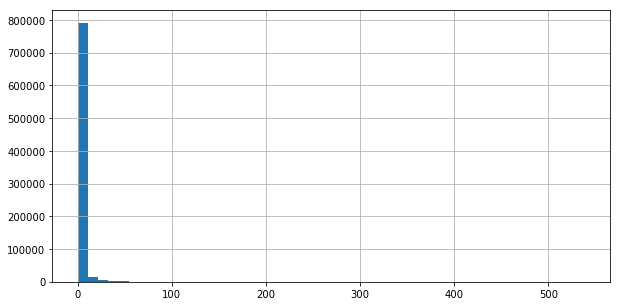

In [94]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [95]:
%%time
mean_error2 = []
total_error2 = []
Proc2 = copy.copy(procedures)
predict_Proc2 = copy.copy(procedures)
abs_pr_error2 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_error2.append(error)
    total_error2.append(abs_error)
    Proc2.append(total_yts)
    predict_Proc2.append(total_p)
    abs_pr_error2.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_error2))
print('Mean Abs Error = %.5f' % np.mean(total_error2))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_error2))

Week 128 - Error 0.54993, Real Total 8171.0 - Predict Total 12750.1, Abs Error 4579.1, Persent - 56.0
Week 129 - Error 0.48374, Real Total 8478.0 - Predict Total 10288.6, Abs Error 1810.6, Persent - 21.4
Week 130 - Error 0.48256, Real Total 10689.0 - Predict Total 8367.1, Abs Error 2321.9, Persent - 21.7
Week 131 - Error 0.48506, Real Total 10552.0 - Predict Total 9763.1, Abs Error 788.9, Persent - 7.5
Week 132 - Error 0.52394, Real Total 6931.0 - Predict Total 10383.0, Abs Error 3452.0, Persent - 49.8
Week 133 - Error 0.49855, Real Total 5732.0 - Predict Total 8218.5, Abs Error 2486.5, Persent - 43.4
Week 134 - Error 0.45226, Real Total 6028.0 - Predict Total 6380.0, Abs Error 352.0, Persent - 5.8
Week 135 - Error 0.47794, Real Total 8726.0 - Predict Total 6171.7, Abs Error 2554.3, Persent - 29.3
Week 136 - Error 0.49026, Real Total 11009.0 - Predict Total 7836.9, Abs Error 3172.1, Persent - 28.8
Week 137 - Error 0.49734, Real Total 7739.0 - Predict Total 10021.8, Abs Error 2282.8, Pe

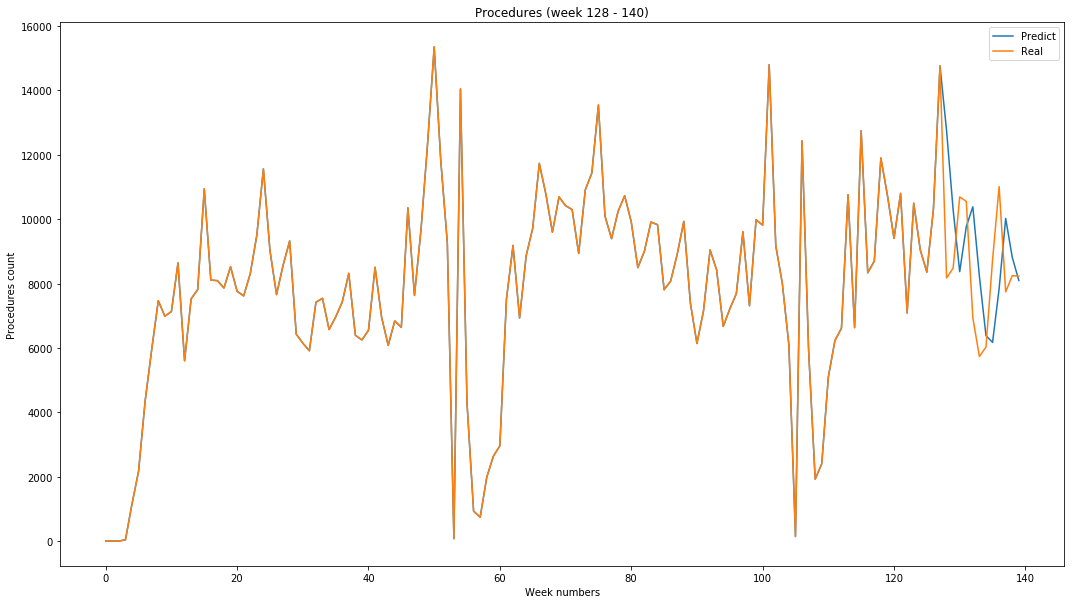

In [96]:
plt.plot(predict_Proc2)
plt.plot(Proc2)
plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [97]:
%%time
mean_errorRF2 = []
total_errorRF2 = []
ProcRF2 = copy.copy(procedures)
predict_ProcRF2 = copy.copy(procedures)
abs_pr_errorRF2 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF2.append(error)
    total_errorRF2.append(abs_error)
    ProcRF2.append(total_yts)
    predict_ProcRF2.append(total_p)
    abs_pr_errorRF2.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF2))

Week 128 - Error 0.66466, Real Total 8171.0 - Predict Total 17806.3, Abs Error 9635.3, Persent - 117.9
Week 129 - Error 0.51059, Real Total 8478.0 - Predict Total 10734.0, Abs Error 2256.0, Persent - 26.6
Week 130 - Error 0.52205, Real Total 10689.0 - Predict Total 8547.5, Abs Error 2141.5, Persent - 20.0
Week 131 - Error 0.54386, Real Total 10552.0 - Predict Total 11960.3, Abs Error 1408.3, Persent - 13.3
Week 132 - Error 0.57968, Real Total 6931.0 - Predict Total 12181.0, Abs Error 5250.0, Persent - 75.7
Week 133 - Error 0.50475, Real Total 5732.0 - Predict Total 7719.8, Abs Error 1987.8, Persent - 34.7
Week 134 - Error 0.48002, Real Total 6028.0 - Predict Total 5909.5, Abs Error 118.5, Persent - 2.0
Week 135 - Error 0.49590, Real Total 8726.0 - Predict Total 6306.4, Abs Error 2419.6, Persent - 27.7
Week 136 - Error 0.51391, Real Total 11009.0 - Predict Total 9563.3, Abs Error 1445.7, Persent - 13.1
Week 137 - Error 0.60294, Real Total 7739.0 - Predict Total 13552.9, Abs Error 5813.9

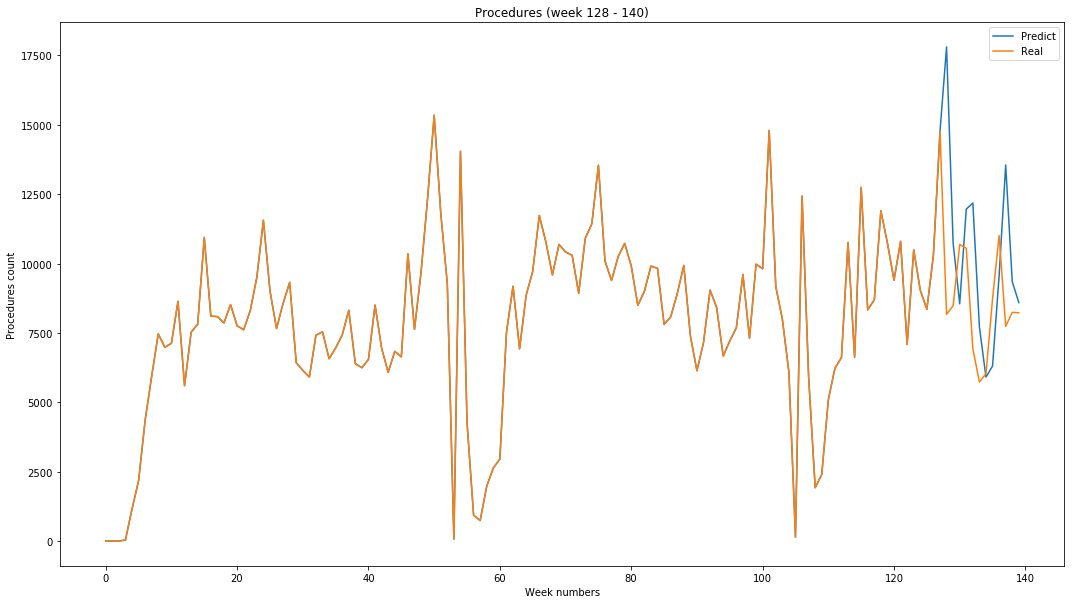

In [98]:
plt.plot(predict_ProcRF2)
plt.plot(ProcRF2)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [99]:
melt3 = melt.copy()
melt3['Last_Week_Proc'] = melt3.groupby(['UnKod'])['Proc'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['UnKod'])['Last_Week_Proc'].diff()
melt3['Last-1_Week_Proc'] = melt3.groupby(['UnKod'])['Proc'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['UnKod'])['Last-1_Week_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,UnKod,Week,Proc,Last_Week_Proc,Last_Week_Diff,Last-1_Week_Proc,Last-1_Week_Diff
17506,102,4,0,0.0,0.0,0.0,0.0
22798,102,5,0,0.0,0.0,0.0,0.0
28090,102,6,0,0.0,0.0,0.0,0.0
33382,102,7,0,0.0,0.0,0.0,0.0
38674,102,8,0,0.0,0.0,0.0,0.0


In [100]:
%%time
mean_errorRF3 = []
total_errorRF3 = []
ProcRF3 = copy.copy(procedures)
predict_ProcRF3 = copy.copy(procedures)
abs_pr_errorRF3 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF3.append(error)
    total_errorRF3.append(abs_error)
    ProcRF3.append(total_yts)
    predict_ProcRF3.append(total_p)
    abs_pr_errorRF3.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF3))

Week 128 - Error 0.66466, Real Total 8171.0 - Predict Total 17806.3, Abs Error 9635.3, Persent - 117.9
Week 129 - Error 0.51059, Real Total 8478.0 - Predict Total 10734.0, Abs Error 2256.0, Persent - 26.6
Week 130 - Error 0.52205, Real Total 10689.0 - Predict Total 8547.5, Abs Error 2141.5, Persent - 20.0
Week 131 - Error 0.54386, Real Total 10552.0 - Predict Total 11960.3, Abs Error 1408.3, Persent - 13.3
Week 132 - Error 0.57968, Real Total 6931.0 - Predict Total 12181.0, Abs Error 5250.0, Persent - 75.7
Week 133 - Error 0.50475, Real Total 5732.0 - Predict Total 7719.8, Abs Error 1987.8, Persent - 34.7
Week 134 - Error 0.48002, Real Total 6028.0 - Predict Total 5909.5, Abs Error 118.5, Persent - 2.0
Week 135 - Error 0.49590, Real Total 8726.0 - Predict Total 6306.4, Abs Error 2419.6, Persent - 27.7
Week 136 - Error 0.51391, Real Total 11009.0 - Predict Total 9563.3, Abs Error 1445.7, Persent - 13.1
Week 137 - Error 0.60294, Real Total 7739.0 - Predict Total 13552.9, Abs Error 5813.9

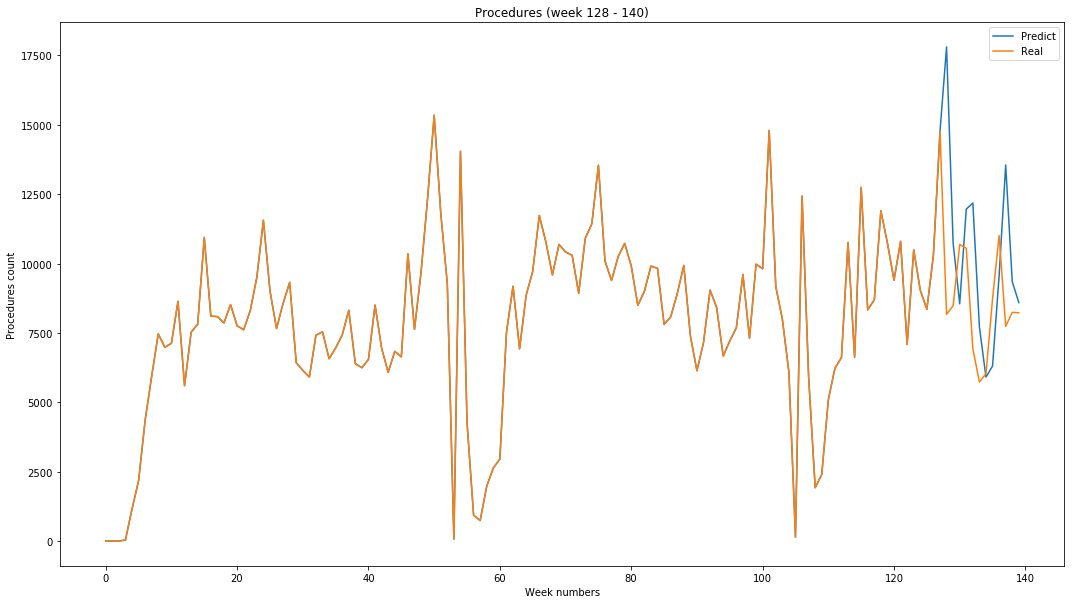

In [101]:
plt.plot(predict_ProcRF3)
plt.plot(ProcRF3)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [102]:
melt4 = melt.copy()
melt4['Last_Week_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['UnKod'])['Last_Week_Proc'].diff()
melt4['Last-1_Week_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['UnKod'])['Last-1_Week_Proc'].diff()
melt4['Last-2_Week_Proc'] = melt4.groupby(['UnKod'])['Proc'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['UnKod'])['Last-2_Week_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,UnKod,Week,Proc,Last_Week_Proc,Last_Week_Diff,Last-1_Week_Proc,Last-1_Week_Diff,Last-2_Week_Proc,Last-2_Week_Diff
22798,102,5,0,0.0,0.0,0.0,0.0,0.0,0.0
28090,102,6,0,0.0,0.0,0.0,0.0,0.0,0.0
33382,102,7,0,0.0,0.0,0.0,0.0,0.0,0.0
38674,102,8,0,0.0,0.0,0.0,0.0,0.0,0.0
43966,102,9,0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
%%time
mean_errorRF4 = []
total_errorRF4 = []
ProcRF4 = copy.copy(procedures)
predict_ProcRF4 = copy.copy(procedures)
abs_pr_errorRF4 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4.append(error)
    total_errorRF4.append(abs_error)
    ProcRF4.append(total_yts)
    predict_ProcRF4.append(total_p)
    abs_pr_errorRF4.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4))

Week 128 - Error 0.66466, Real Total 8171.0 - Predict Total 17806.3, Abs Error 9635.3, Persent - 117.9
Week 129 - Error 0.51059, Real Total 8478.0 - Predict Total 10734.0, Abs Error 2256.0, Persent - 26.6
Week 130 - Error 0.52205, Real Total 10689.0 - Predict Total 8547.5, Abs Error 2141.5, Persent - 20.0
Week 131 - Error 0.54386, Real Total 10552.0 - Predict Total 11960.3, Abs Error 1408.3, Persent - 13.3
Week 132 - Error 0.57968, Real Total 6931.0 - Predict Total 12181.0, Abs Error 5250.0, Persent - 75.7
Week 133 - Error 0.50475, Real Total 5732.0 - Predict Total 7719.8, Abs Error 1987.8, Persent - 34.7
Week 134 - Error 0.48002, Real Total 6028.0 - Predict Total 5909.5, Abs Error 118.5, Persent - 2.0
Week 135 - Error 0.49590, Real Total 8726.0 - Predict Total 6306.4, Abs Error 2419.6, Persent - 27.7
Week 136 - Error 0.51391, Real Total 11009.0 - Predict Total 9563.3, Abs Error 1445.7, Persent - 13.1
Week 137 - Error 0.60294, Real Total 7739.0 - Predict Total 13552.9, Abs Error 5813.9

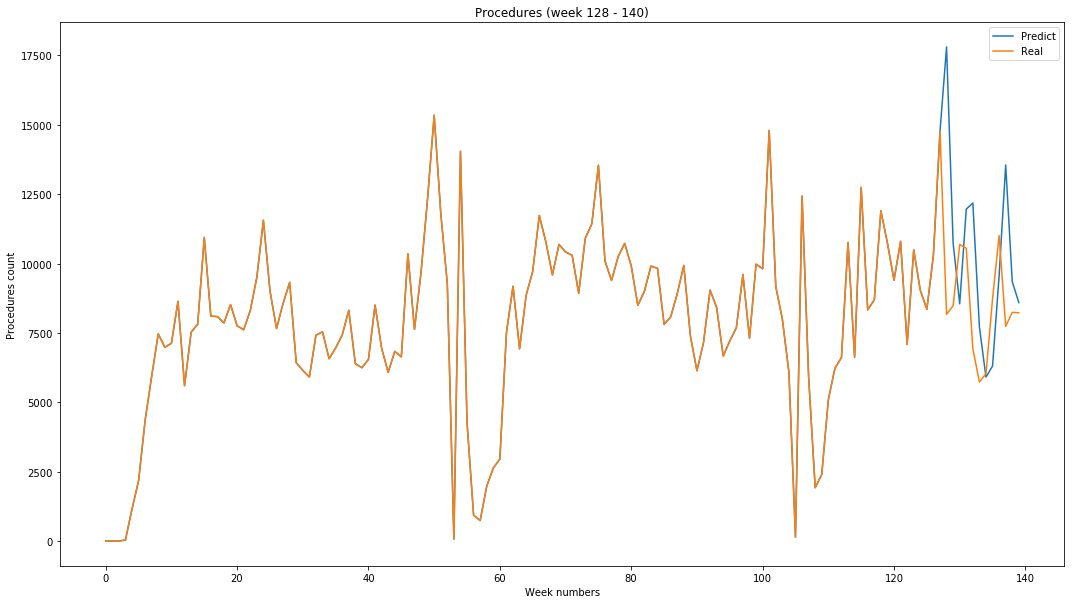

In [104]:
plt.plot(predict_ProcRF4)
plt.plot(ProcRF4)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [105]:
%%time
mean_errorRF4_n = []
total_errorRF4_n = []
ProcRF4_n = copy.copy(procedures)
predict_ProcRF4_n = copy.copy(procedures)
abs_pr_errorRF4_n = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4_n.append(error)
    total_errorRF4_n.append(abs_error)
    ProcRF4_n.append(total_yts)
    predict_ProcRF4_n.append(total_p)
    abs_pr_errorRF4.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4_n))

Week 128 - Error 0.56096, Real Total 8171.0 - Predict Total 12498.2, Abs Error 4327.2, Persent - 53.0
Week 129 - Error 0.46901, Real Total 8478.0 - Predict Total 6623.3, Abs Error 1854.7, Persent - 21.9
Week 130 - Error 0.52513, Real Total 10689.0 - Predict Total 6084.1, Abs Error 4604.9, Persent - 43.1
Week 131 - Error 0.49780, Real Total 10552.0 - Predict Total 8865.7, Abs Error 1686.3, Persent - 16.0
Week 132 - Error 0.49200, Real Total 6931.0 - Predict Total 9113.6, Abs Error 2182.6, Persent - 31.5
Week 133 - Error 0.44907, Real Total 5732.0 - Predict Total 5181.4, Abs Error 550.6, Persent - 9.6
Week 134 - Error 0.45991, Real Total 6028.0 - Predict Total 4019.1, Abs Error 2008.9, Persent - 33.3
Week 135 - Error 0.50404, Real Total 8726.0 - Predict Total 4413.8, Abs Error 4312.2, Persent - 49.4
Week 136 - Error 0.50620, Real Total 11009.0 - Predict Total 6713.5, Abs Error 4295.5, Persent - 39.0
Week 137 - Error 0.51318, Real Total 7739.0 - Predict Total 10113.3, Abs Error 2374.3, Pe

C:\Users\solod\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\solod\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


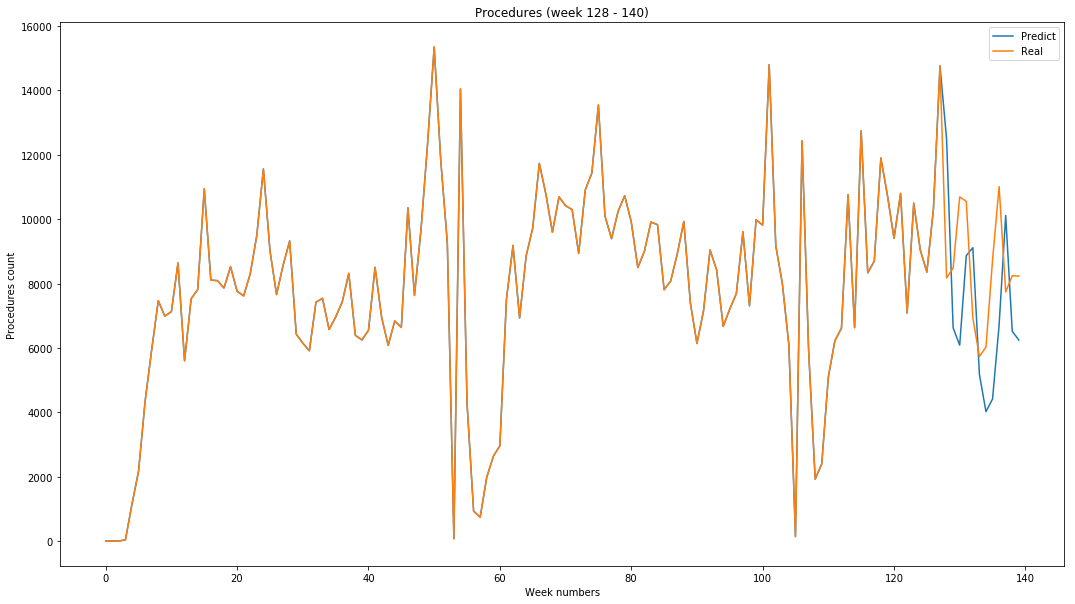

In [106]:
plt.plot(predict_ProcRF4_n)
plt.plot(ProcRF4_n)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [107]:
%%time
mean_errorGB4 = []
total_errorGB4 = []
ProcGB4 = copy.copy(procedures)
predict_ProcGB4 = copy.copy(procedures)
abs_pr_errorGB4 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorGB4.append(error)
    total_errorGB4.append(abs_error)
    ProcGB4.append(total_yts)
    predict_ProcGB4.append(total_p)
    abs_pr_errorGB4.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorGB4))

Week 128 - Error 0.52476, Real Total 8171.0 - Predict Total 13449.3, Abs Error 5278.3, Persent - 64.6
Week 129 - Error 0.42951, Real Total 8478.0 - Predict Total 5909.2, Abs Error 2568.8, Persent - 30.3
Week 130 - Error 0.49355, Real Total 10689.0 - Predict Total 5480.3, Abs Error 5208.7, Persent - 48.7
Week 131 - Error 0.45286, Real Total 10552.0 - Predict Total 9086.4, Abs Error 1465.6, Persent - 13.9
Week 132 - Error 0.45698, Real Total 6931.0 - Predict Total 8930.7, Abs Error 1999.7, Persent - 28.9
Week 133 - Error 0.40430, Real Total 5732.0 - Predict Total 4619.0, Abs Error 1113.0, Persent - 19.4
Week 134 - Error 0.42149, Real Total 6028.0 - Predict Total 3495.4, Abs Error 2532.6, Persent - 42.0
Week 135 - Error 0.48180, Real Total 8726.0 - Predict Total 4127.0, Abs Error 4599.0, Persent - 52.7
Week 136 - Error 0.47369, Real Total 11009.0 - Predict Total 7358.4, Abs Error 3650.6, Persent - 33.2
Week 137 - Error 0.47291, Real Total 7739.0 - Predict Total 10324.7, Abs Error 2585.7, 

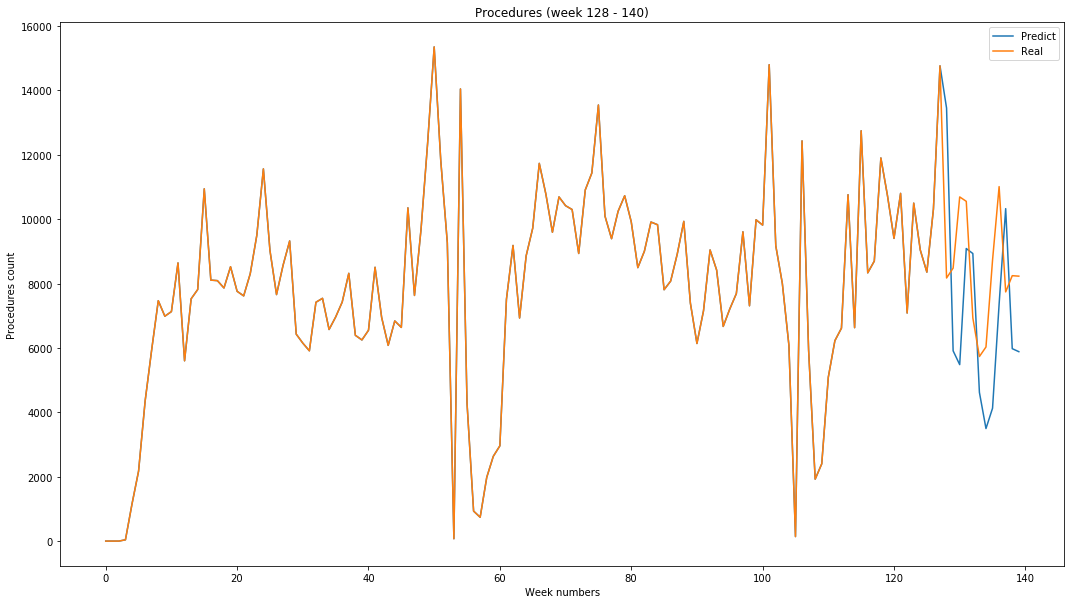

In [108]:
plt.plot(predict_ProcGB4)
plt.plot(ProcGB4)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [109]:
melt52 = melt.copy()
melt52['Last_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift()
melt52['Last_Week_Diff'] = melt52.groupby(['UnKod'])['Last_Week_Proc'].diff()
melt52['Last-1_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-1_Week_Diff'] = melt52.groupby(['UnKod'])['Last-1_Week_Proc'].diff()
melt52['Last-2_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-2_Week_Diff'] = melt52.groupby(['UnKod'])['Last-2_Week_Proc'].diff()
melt52['Last-3_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-3_Week_Diff'] = melt52.groupby(['UnKod'])['Last-3_Week_Proc'].diff()
melt52['Last-4_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-4_Week_Diff'] = melt52.groupby(['UnKod'])['Last-4_Week_Proc'].diff()
melt52['Last-5_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-5_Week_Diff'] = melt52.groupby(['UnKod'])['Last-5_Week_Proc'].diff()
melt52['Last-6_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-6_Week_Diff'] = melt52.groupby(['UnKod'])['Last-6_Week_Proc'].diff()
melt52['Last-7_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-7_Week_Diff'] = melt52.groupby(['UnKod'])['Last-7_Week_Proc'].diff()
melt52['Last-8_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-8_Week_Diff'] = melt52.groupby(['UnKod'])['Last-8_Week_Proc'].diff()
melt52['Last-9_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-9_Week_Diff'] = melt52.groupby(['UnKod'])['Last-9_Week_Proc'].diff()
melt52['Last-10_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-10_Week_Diff'] = melt52.groupby(['UnKod'])['Last-10_Week_Proc'].diff()
melt52['Last-11_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-11_Week_Diff'] = melt52.groupby(['UnKod'])['Last-11_Week_Proc'].diff()
melt52['Last-12_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-12_Week_Diff'] = melt52.groupby(['UnKod'])['Last-12_Week_Proc'].diff()
melt52['Last-13_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-13_Week_Diff'] = melt52.groupby(['UnKod'])['Last-13_Week_Proc'].diff()
melt52['Last-14_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-14_Week_Diff'] = melt52.groupby(['UnKod'])['Last-14_Week_Proc'].diff()
melt52['Last-15_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-15_Week_Diff'] = melt52.groupby(['UnKod'])['Last-15_Week_Proc'].diff()
melt52['Last-16_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-16_Week_Diff'] = melt52.groupby(['UnKod'])['Last-16_Week_Proc'].diff()
melt52['Last-17_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-17_Week_Diff'] = melt52.groupby(['UnKod'])['Last-17_Week_Proc'].diff()
melt52['Last-18_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-18_Week_Diff'] = melt52.groupby(['UnKod'])['Last-18_Week_Proc'].diff()
melt52['Last-19_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-19_Week_Diff'] = melt52.groupby(['UnKod'])['Last-19_Week_Proc'].diff()
melt52['Last-20_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-20_Week_Diff'] = melt52.groupby(['UnKod'])['Last-20_Week_Proc'].diff()
melt52['Last-21_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-21_Week_Diff'] = melt52.groupby(['UnKod'])['Last-21_Week_Proc'].diff()
melt52['Last-22_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-22_Week_Diff'] = melt52.groupby(['UnKod'])['Last-22_Week_Proc'].diff()
melt52['Last-23_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-23_Week_Diff'] = melt52.groupby(['UnKod'])['Last-23_Week_Proc'].diff()
melt52['Last-24_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-24_Week_Diff'] = melt52.groupby(['UnKod'])['Last-24_Week_Proc'].diff()
melt52['Last-25_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-25_Week_Diff'] = melt52.groupby(['UnKod'])['Last-25_Week_Proc'].diff()
melt52['Last-26_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-26_Week_Diff'] = melt52.groupby(['UnKod'])['Last-26_Week_Proc'].diff()
melt52['Last-27_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-27_Week_Diff'] = melt52.groupby(['UnKod'])['Last-27_Week_Proc'].diff()
melt52['Last-28_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-28_Week_Diff'] = melt52.groupby(['UnKod'])['Last-28_Week_Proc'].diff()
melt52['Last-29_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-29_Week_Diff'] = melt52.groupby(['UnKod'])['Last-29_Week_Proc'].diff()
melt52['Last-30_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-30_Week_Diff'] = melt52.groupby(['UnKod'])['Last-30_Week_Proc'].diff()
melt52['Last-31_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-31_Week_Diff'] = melt52.groupby(['UnKod'])['Last-31_Week_Proc'].diff()
melt52['Last-32_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-32_Week_Diff'] = melt52.groupby(['UnKod'])['Last-32_Week_Proc'].diff()
melt52['Last-33_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-33_Week_Diff'] = melt52.groupby(['UnKod'])['Last-33_Week_Proc'].diff()
melt52['Last-34_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-34_Week_Diff'] = melt52.groupby(['UnKod'])['Last-34_Week_Proc'].diff()
melt52['Last-35_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-35_Week_Diff'] = melt52.groupby(['UnKod'])['Last-35_Week_Proc'].diff()
melt52['Last-36_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-36_Week_Diff'] = melt52.groupby(['UnKod'])['Last-36_Week_Proc'].diff()
melt52['Last-37_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-37_Week_Diff'] = melt52.groupby(['UnKod'])['Last-37_Week_Proc'].diff()
melt52['Last-38_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-38_Week_Diff'] = melt52.groupby(['UnKod'])['Last-38_Week_Proc'].diff()
melt52['Last-39_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-39_Week_Diff'] = melt52.groupby(['UnKod'])['Last-39_Week_Proc'].diff()
melt52['Last-40_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-40_Week_Diff'] = melt52.groupby(['UnKod'])['Last-40_Week_Proc'].diff()
melt52['Last-41_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-41_Week_Diff'] = melt52.groupby(['UnKod'])['Last-41_Week_Proc'].diff()
melt52['Last-42_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-42_Week_Diff'] = melt52.groupby(['UnKod'])['Last-42_Week_Proc'].diff()
melt52['Last-43_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-43_Week_Diff'] = melt52.groupby(['UnKod'])['Last-43_Week_Proc'].diff()
melt52['Last-44_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-44_Week_Diff'] = melt52.groupby(['UnKod'])['Last-44_Week_Proc'].diff()
melt52['Last-45_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-45_Week_Diff'] = melt52.groupby(['UnKod'])['Last-45_Week_Proc'].diff()
melt52['Last-46_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-46_Week_Diff'] = melt52.groupby(['UnKod'])['Last-46_Week_Proc'].diff()
melt52['Last-47_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-47_Week_Diff'] = melt52.groupby(['UnKod'])['Last-47_Week_Proc'].diff()
melt52['Last-48_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-48_Week_Diff'] = melt52.groupby(['UnKod'])['Last-48_Week_Proc'].diff()
melt52['Last-49_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-49_Week_Diff'] = melt52.groupby(['UnKod'])['Last-49_Week_Proc'].diff()
melt52['Last-50_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-50_Week_Diff'] = melt52.groupby(['UnKod'])['Last-50_Week_Proc'].diff()
melt52['Last-51_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(2)
melt52['Last-51_Week_Diff'] = melt52.groupby(['UnKod'])['Last-51_Week_Proc'].diff()
melt52['Last-52_Week_Proc'] = melt52.groupby(['UnKod'])['Proc'].shift(3)
melt52['Last-52_Week_Diff'] = melt52.groupby(['UnKod'])['Last-52_Week_Proc'].diff()
melt52 = melt52.dropna()
melt52.head()

,UnKod,Week,Proc,Last_Week_Proc,Last_Week_Diff,Last-1_Week_Proc,Last-1_Week_Diff,Last-2_Week_Proc,Last-2_Week_Diff,Last-3_Week_Proc,...,Last-48_Week_Proc,Last-48_Week_Diff,Last-49_Week_Proc,Last-49_Week_Diff,Last-50_Week_Proc,Last-50_Week_Diff,Last-51_Week_Proc,Last-51_Week_Diff,Last-52_Week_Proc,Last-52_Week_Diff
22798,102,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28090,102,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33382,102,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38674,102,8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43966,102,9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
%%time
mean_errorRF52 = []
total_errorRF52 = []
ProcRF52 = copy.copy(procedures)
predict_ProcRF52 = copy.copy(procedures)
abs_pr_errorRF52 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF52.append(error)
    total_errorRF52.append(abs_error)
    ProcRF52.append(total_yts)
    predict_ProcRF52.append(total_p)
    abs_pr_errorRF52.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF52))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF52))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF52))

Week 128 - Error 0.66466, Real Total 8171.0 - Predict Total 17806.3, Abs Error 9635.3, Persent - 117.9
Week 129 - Error 0.51059, Real Total 8478.0 - Predict Total 10734.0, Abs Error 2256.0, Persent - 26.6
Week 130 - Error 0.52205, Real Total 10689.0 - Predict Total 8547.5, Abs Error 2141.5, Persent - 20.0
Week 131 - Error 0.54386, Real Total 10552.0 - Predict Total 11960.3, Abs Error 1408.3, Persent - 13.3
Week 132 - Error 0.57968, Real Total 6931.0 - Predict Total 12181.0, Abs Error 5250.0, Persent - 75.7
Week 133 - Error 0.50475, Real Total 5732.0 - Predict Total 7719.8, Abs Error 1987.8, Persent - 34.7
Week 134 - Error 0.48002, Real Total 6028.0 - Predict Total 5909.5, Abs Error 118.5, Persent - 2.0
Week 135 - Error 0.49590, Real Total 8726.0 - Predict Total 6306.4, Abs Error 2419.6, Persent - 27.7
Week 136 - Error 0.51391, Real Total 11009.0 - Predict Total 9563.3, Abs Error 1445.7, Persent - 13.1
Week 137 - Error 0.60294, Real Total 7739.0 - Predict Total 13552.9, Abs Error 5813.9

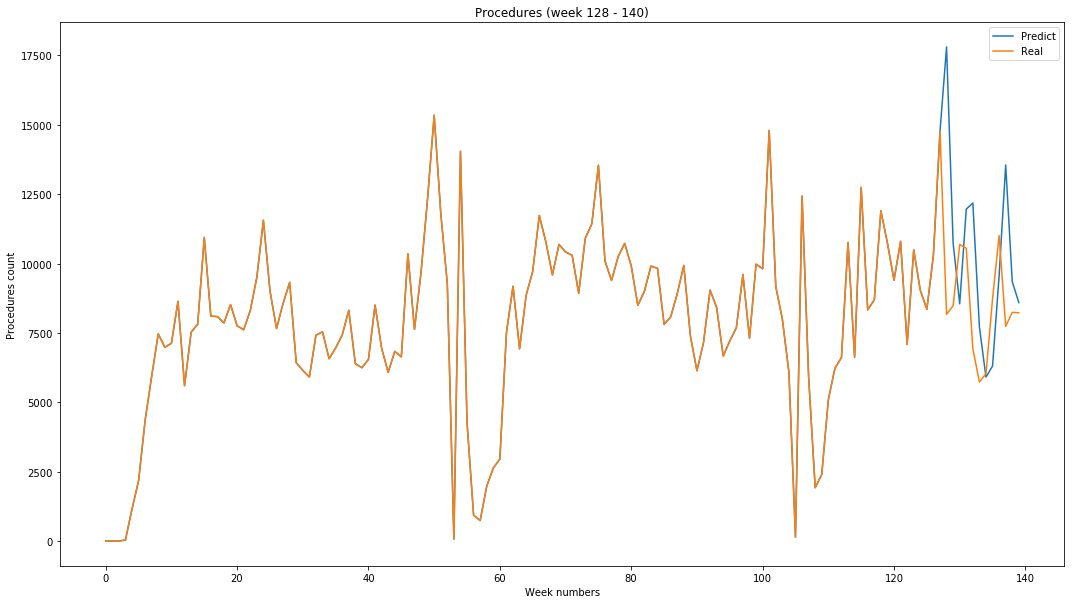

In [111]:
plt.plot(predict_ProcRF52)
plt.plot(ProcRF52)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [112]:
%%time
mean_errorGB52 = []
total_errorGB52 = []
ProcGB52 = copy.copy(procedures)
predict_ProcGB52 = copy.copy(procedures)
abs_pr_errorGB52 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorGB52.append(error)
    total_errorGB52.append(abs_error)
    ProcGB52.append(total_yts)
    predict_ProcGB52.append(total_p)
    abs_pr_errorGB52.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorGB52))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB52))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorGB52))

Week 128 - Error 0.52476, Real Total 8171.0 - Predict Total 13449.3, Abs Error 5278.3, Persent - 64.6
Week 129 - Error 0.42951, Real Total 8478.0 - Predict Total 5909.2, Abs Error 2568.8, Persent - 30.3
Week 130 - Error 0.49355, Real Total 10689.0 - Predict Total 5480.3, Abs Error 5208.7, Persent - 48.7
Week 131 - Error 0.45286, Real Total 10552.0 - Predict Total 9086.4, Abs Error 1465.6, Persent - 13.9
Week 132 - Error 0.45698, Real Total 6931.0 - Predict Total 8930.7, Abs Error 1999.7, Persent - 28.9
Week 133 - Error 0.40430, Real Total 5732.0 - Predict Total 4619.0, Abs Error 1113.0, Persent - 19.4
Week 134 - Error 0.42149, Real Total 6028.0 - Predict Total 3495.4, Abs Error 2532.6, Persent - 42.0
Week 135 - Error 0.48180, Real Total 8726.0 - Predict Total 4127.0, Abs Error 4599.0, Persent - 52.7
Week 136 - Error 0.47369, Real Total 11009.0 - Predict Total 7358.4, Abs Error 3650.6, Persent - 33.2
Week 137 - Error 0.47291, Real Total 7739.0 - Predict Total 10324.7, Abs Error 2585.7, 

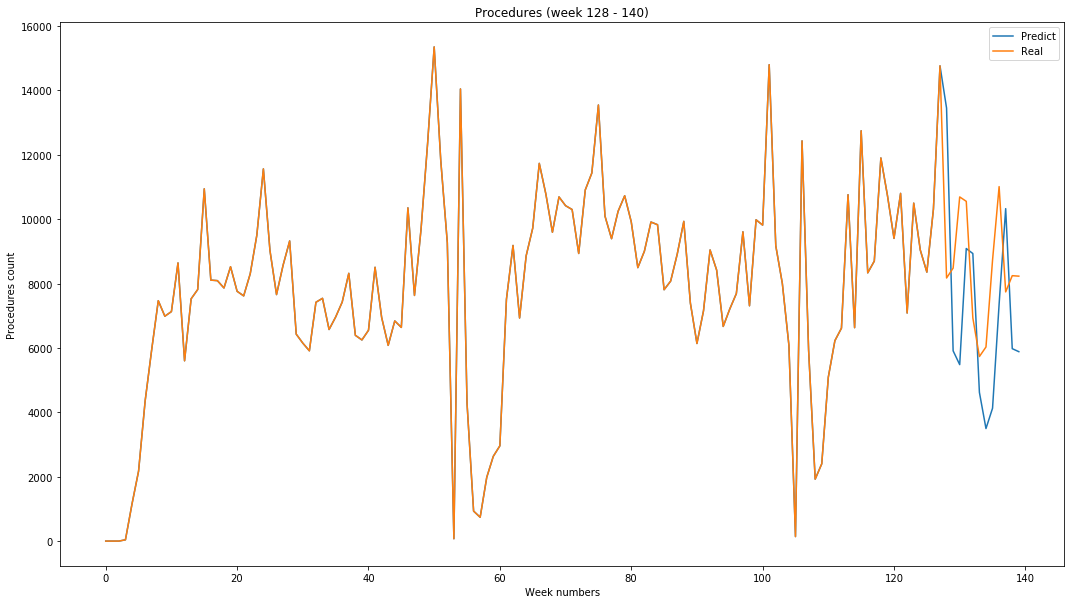

In [113]:
plt.plot(predict_ProcGB52)
plt.plot(ProcGB52)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [114]:
%%time
mean_errorLR52 = []
total_errorLR52 = []
ProcLR52 = copy.copy(procedures)
predict_ProcLR52 = copy.copy(procedures)
abs_pr_errorLR52 = []
for week in range(week_start, week_end):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Week %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (week, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorLR52.append(error)
    total_errorLR52.append(abs_error)
    ProcLR52.append(total_yts)
    predict_ProcLR52.append(total_p)
    abs_pr_errorLR52.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorLR52))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR52))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorLR52))

Week 128 - Error 0.54993, Real Total 8171.0 - Predict Total 12750.1, Abs Error 4579.1, Persent - 56.0
Week 129 - Error 0.48374, Real Total 8478.0 - Predict Total 10288.6, Abs Error 1810.6, Persent - 21.4
Week 130 - Error 0.48256, Real Total 10689.0 - Predict Total 8367.1, Abs Error 2321.9, Persent - 21.7
Week 131 - Error 0.48506, Real Total 10552.0 - Predict Total 9763.1, Abs Error 788.9, Persent - 7.5
Week 132 - Error 0.52394, Real Total 6931.0 - Predict Total 10383.0, Abs Error 3452.0, Persent - 49.8
Week 133 - Error 0.49855, Real Total 5732.0 - Predict Total 8218.5, Abs Error 2486.5, Persent - 43.4
Week 134 - Error 0.45226, Real Total 6028.0 - Predict Total 6380.0, Abs Error 352.0, Persent - 5.8
Week 135 - Error 0.47794, Real Total 8726.0 - Predict Total 6171.7, Abs Error 2554.3, Persent - 29.3
Week 136 - Error 0.49026, Real Total 11009.0 - Predict Total 7836.9, Abs Error 3172.1, Persent - 28.8
Week 137 - Error 0.49734, Real Total 7739.0 - Predict Total 10021.8, Abs Error 2282.8, Pe

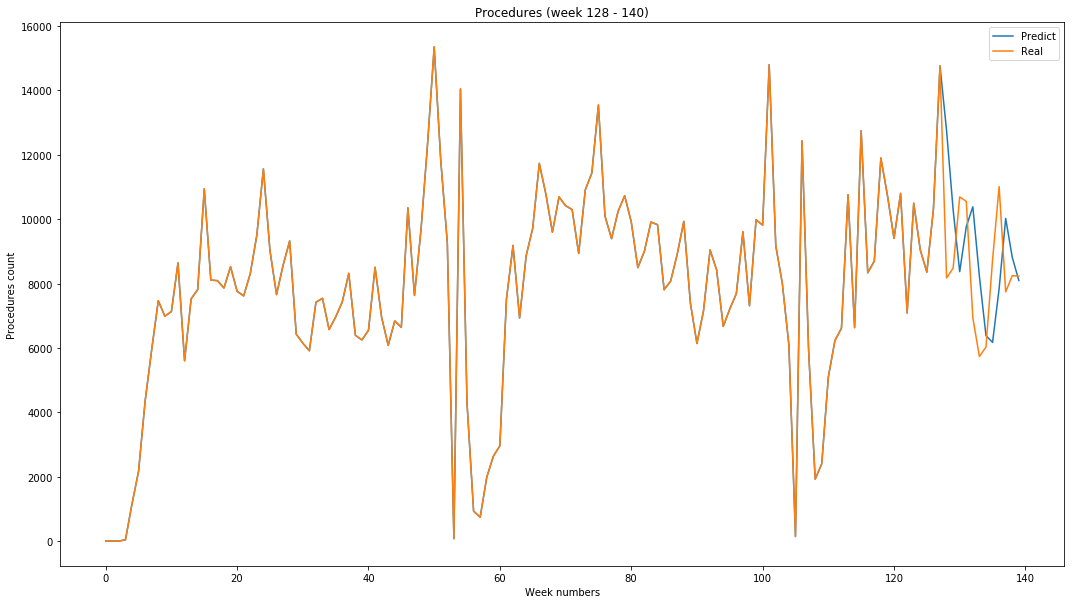

In [115]:
plt.plot(predict_ProcLR52)
plt.plot(ProcLR52)

plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

C:\Users\solod\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\solod\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


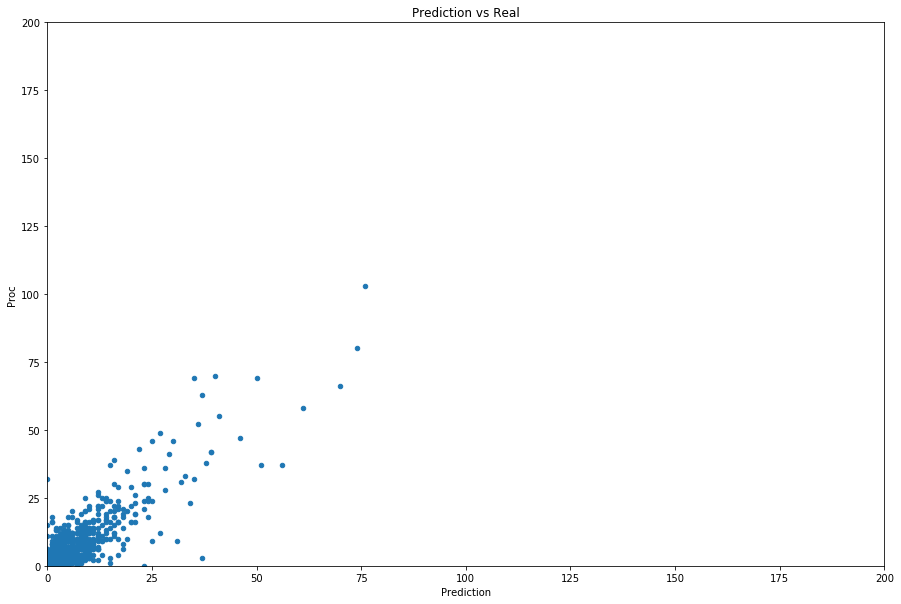

In [116]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200), xlim=(0,200))

In [117]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Abs Error baseline persent = %.5f' % np.mean(abs_pr_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_error2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_error2))
print('Mean Abs Error LR2 persent = %.5f' % np.mean(abs_pr_error2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error RF2 persent = %.5f' % np.mean(abs_pr_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error RF3 persent = %.5f' % np.mean(abs_pr_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error RF4 persent = %.5f' % np.mean(abs_pr_errorRF4))
print('Mean Error RF4_n = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error RF4_n = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error RF4_n persent = %.5f' % np.mean(abs_pr_errorRF4_n))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error GB4 persent = %.5f' % np.mean(abs_pr_errorGB4))
print('Mean Error LR52 = %.5f' % np.mean(mean_errorLR52))
print('Mean Abs Error LR52 = %.5f' % np.mean(total_errorLR52))
print('Mean Abs Error LR52 persent = %.5f' % np.mean(abs_pr_errorLR52))
print('Mean Error RF52 = %.5f' % np.mean(mean_errorRF52))
print('Mean Abs Error RF52 = %.5f' % np.mean(total_errorRF52))
print('Mean Abs Error RF52 persent = %.5f' % np.mean(abs_pr_errorrf52))
print('Mean Error GB52 = %.5f' % np.mean(mean_errorGB52))
print('Mean Abs Error GB52 = %.5f' % np.mean(total_errorGB52))
print('Mean Abs Error GB52 persent = %.5f' % np.mean(abs_pr_errorGB52))

Mean Error baseline = 0.52755
Mean Abs Error baseline = 1927.50000
Mean Abs Error baseline persent = 23.71013
Mean Error LR2 = 0.49003
Mean Abs Error LR2 = 2042.17632
Mean Abs Error LR2 persent = 25.14754
Mean Error RF2 = 0.53374
Mean Abs Error RF2 = 2828.92633
Mean Abs Error RF2 persent = 35.34469
Mean Error RF3 = 0.53374
Mean Abs Error RF3 = 2828.92633
Mean Abs Error RF3 persent = 35.34469
Mean Error RF4 = 0.53374
Mean Abs Error RF4 = 2828.92633
Mean Abs Error RF4 persent = 33.19231
Mean Error RF4_n = 0.49189
Mean Abs Error RF4_n = 2658.88779
Mean Abs Error RF4_n persent = nan
Mean Error GB4 = 0.45687
Mean Abs Error GB4 = 2967.85027
Mean Abs Error GB4 persent = 35.25666
Mean Error LR52 = 0.49003
Mean Abs Error LR52 = 2042.17632
Mean Abs Error LR52 persent = 25.14754
Mean Error RF52 = 0.53374
Mean Abs Error RF52 = 2828.92608


C:\Users\solod\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\solod\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'abs_pr_errorrf52' is not defined

In [ ]:
plt.plot(predict_ProcB)
plt.plot(predict_Proc2)
plt.plot(predict_ProcRF2)
plt.plot(predict_ProcRF52)
plt.plot(predict_ProcGB4)
plt.plot(predict_ProcGB52)
plt.plot(ProcB)
plt.title(s)
plt.xlabel('Week numbers')
plt.ylabel('Procedures count')
plt.legend()